In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(context="talk", style="darkgrid", palette="deep", names=True)
from jupyterthemes import jtplot
jtplot.style(theme="onedork", context="talk", spines=False, gridlines='--')

from PySpice.Spice.Netlist import Circuit
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Unit import *


In [2]:
class VS(Circuit):
    def __init__(self, title, freq, mode, parasitic=0 @u_Ohm, **kwargs):
        super().__init__('sin')
        self._frq = freq
        self._done = False
        
        self.R(0, 'vfull', 'vin', parasitic)

        if "integ" in mode:
            self._integrator(**kwargs)
        elif "diff" in mode or "deriv" in mode:
            self._differentiator(**kwargs)
        elif "damp" in mode:
            self._damped(**kwargs)

    def _integrator(self, R, C):
        if self._done:
            raise Exception("Circuit already done")
        self._done = True
        self.R(1, 'vin', 'vout', R)
        self.C(1, 'vout', self.gnd, C)

    def _differentiator(self, R, C):
        if self._done:
            raise Exception("Circuit already done")
        self._done = True
        self.C(1, 'vin', 'vout', C)
        self.R(1, 'vout', self.gnd, R)

    def _damped(self, R, L, C):
        if self._done:
            raise Exception("Circuit already done")
        self._done = True
        self.R(1, 'vin', 'vintern', R)
        self.L(1, 'vintern', 'vout', L)
        self.C(1, 'vout', self.gnd, C)


    def signal_sim(self, points=1000, cycles=2.5, wait=10, plot=False):
        prd = self._frq.period
        total_time = prd * cycles
        step = total_time/points

        simulator = self.simulator()
        analysis = simulator.transient(step_time=step, end_time=total_time+wait*prd, start_time=wait*prd)

        simulation = pd.DataFrame()
        simulation["time"] = analysis.time
        simulation["time"] = simulation["time"] - np.min(simulation["time"])
        simulation["vin"] = analysis.vin
        simulation["vout"] = analysis.vout
        
        if plot:
            signal_plot(simulation)

        return simulation


In [3]:
class VS_sin(VS):
    def __init__(self, freq, mode, parasitic=0 @u_Ohm, vpp=1 @u_V, offset=0 @u_V, **kwargs):
        super().__init__('quad', freq, mode, parasitic, **kwargs)

        vs_args = {
            "amplitude": vpp/2,
            "frequency": freq,
            "offset": vpp/2 + offset
        }
        self.SinusoidalVoltageSource('input', 'vfull', self.gnd, **vs_args)
        
    def bode_sim(self, start=None, end=None, points=1000, plot=False):
        if not start:
            start = self._frq / 100
        if not end:
            end = self._frq * 100
            
        simulator = self.simulator()
        analysis = simulator.ac(
            start_frequency = start,
            stop_frequency = end,
            number_of_points = points,
            variation = 'dec'
        )

        simulation = pd.DataFrame()
        simulation["freq"] = analysis.frequency
        simulation["vin"] = analysis.vin
        simulation["vout"] = analysis.vout
        simulation["xmit"] = 20 * np.log10(analysis.vout/analysis.vin)
        simulation["phase"] = np.angle(analysis.vout, deg=True)
        
        if plot:
            bode_plot(simulation)

        return simulation


class VS_quad(VS):
    def __init__(self, freq, mode, parasitic=0 @u_Ohm, vpp=1 @u_V, duty=.5, offset=0 @u_V, **kwargs):
        super().__init__('quad', freq, mode, parasitic, **kwargs)
        self._frq = freq

        vs_args = {
            "initial_value": offset,
            "pulsed_value": vpp + offset,
            "period": freq.period,
            "pulse_width": duty * freq.period
        }
        self.PulseVoltageSource('input', 'vfull', self.gnd, **vs_args)
        
class VS_tri(VS):
    def __init__(self, freq, mode, parasitic=0 @u_Ohm, vpp=1 @u_V, duty=.5, offset=0 @u_V, **kwargs):
        super().__init__('quad', freq, mode, parasitic, **kwargs)
        self._frq = freq

        vs_args = {
            "initial_value": offset,
            "pulsed_value": vpp + offset,
            "period": freq.period,
            "pulse_width": 0.0001 * freq.period,
            "rise_time": duty * freq.period,
            "fall_time": (1.-duty) * freq.period
        }
        self.PulseVoltageSource('input', 'vfull', self.gnd, **vs_args)


In [4]:
def signal_plot(signal):
    fig, (vin, vout) = plt.subplots(2, 1, sharey=True, figsize=(12, 12))

    sns.lineplot(x="time", y="vin", color='r', ax=vin, data=signal)
    sns.lineplot(x="time", y="vout", color='b', ax=vout, data=signal)

    plt.show()

def bode_plot(signal):
    fig, (xmit, phase) = plt.subplots(2, 1, figsize=(12, 12))
    
    xmit.set_xscale("log")
    phase.set_xscale("log")
    phase.set_ylim(-100., 100.)
    phase.set_yticks([-90, -60, -30, 0, 30, 60, 90])
    
    sns.lineplot(x="freq", y="xmit", color='r', ax=xmit, data=signal)
    sns.lineplot(x="freq", y="phase", color='b', ax=phase, data=signal)

    plt.show()


In [5]:
def xmit(signal, rms=False):
    if not rms:
        vi = max(signal["vin"]) - min(signal["vin"])
        vo = max(signal["vout"]) - min(signal["vout"])

    if rms:
        vi_stable = (max(signal["vin"]) + min(signal["vin"]))/2
        vo_stable = (max(signal["vout"]) + min(signal["vout"]))/2

        vi = np.sqrt(sum(np.square(signal["vin"] - vi_stable)))
        vo = np.sqrt(sum(np.square(signal["vout"] - vo_stable)))

    xmit = 20 * np.log10(vo/vi)
    return xmit


# Parte 1

# Parte 2

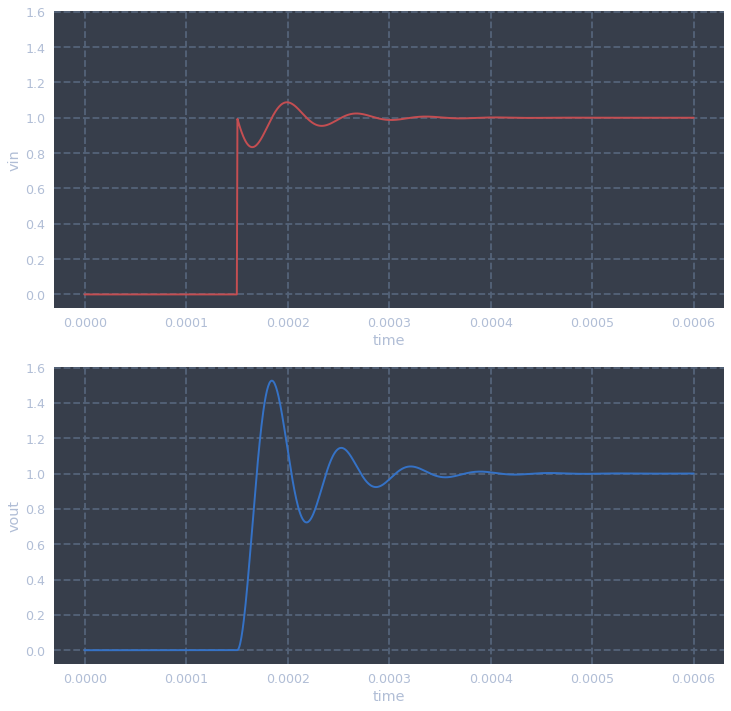

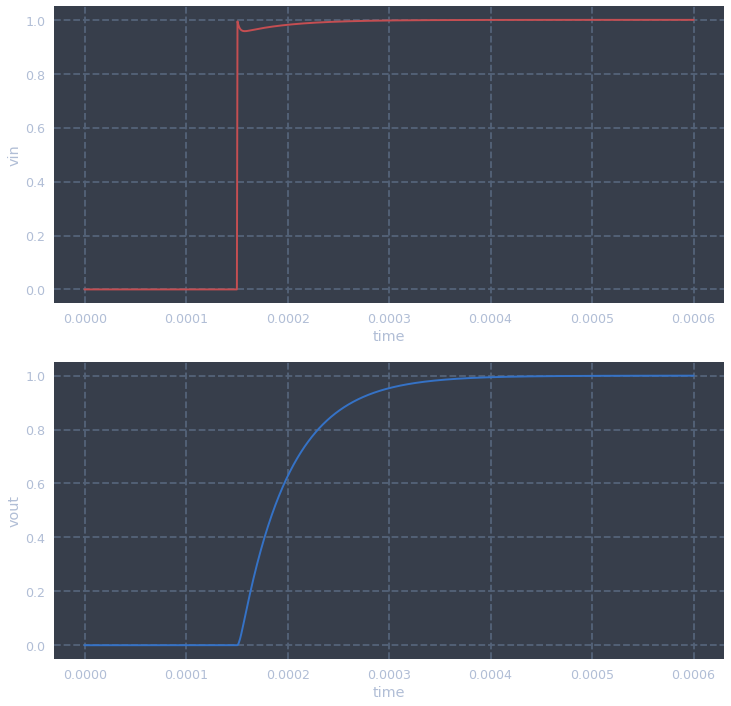

In [12]:
path = "dados/sim/"

components = {
    "parasitic": 50 + 50j, #Ohm
    "C": 47 @u_nF,
    "L": 2.42 @u_mH
}
prec = 30
sim_args = {
    "cycles": prec/100,
    "wait": 10 - prec/400,
    "plot": True
}

for R in 41 @u_Ohm, 1021 @u_Ohm:
    signal = VS_quad(500 @u_Hz, mode="damped", R=R, **components).signal_sim(**sim_args)

    file_path = path + str(R.value) + "o.csv"
    signal.to_csv(file_path, index=False)